In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
from matplotlib import pyplot as plt

# Convolutional Neural Network
## CIFAR-10 Image Classification
### 1. Loading the dataset

In [2]:
torch.manual_seed(0)

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
trainset = datasets.CIFAR10(
    root='~/Downloads/',
    train=True,
    download=True,
    transform=transform
)

testset = datasets.CIFAR10(
    root='~/Downloads/',
    train=False,
    download=True,
    transform=transform
)

batchsize = 64
trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testloader = DataLoader(testset, batch_size=batchsize, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


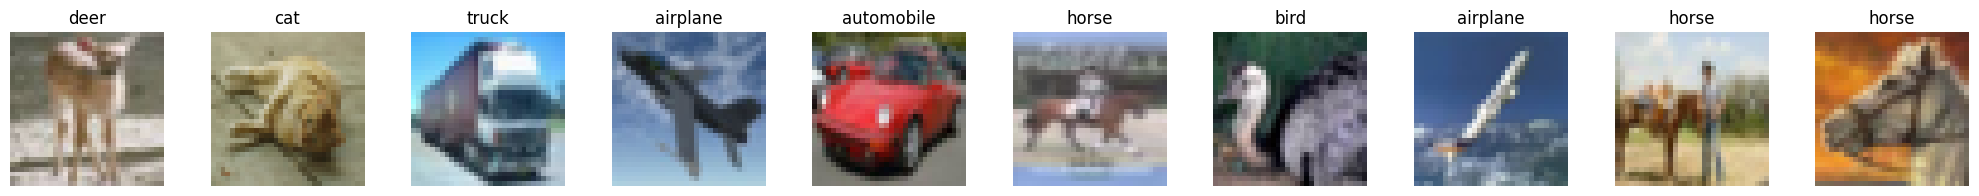

In [3]:
transform_back = transforms.Compose([transforms.Normalize((-1.,-1.,-1.),(2.,2.,2.)), 
                            transforms.ToPILImage()])
images, labels =  next(iter(trainloader))

idx_to_class = {value: key for key, value in trainset.class_to_idx.items()}

plt.figure(figsize=(20,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[labels[i].item()])
plt.show()


### 2. Build a convolutional neural network (CNN) for classification

In [4]:
device = torch.device('mps')
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class MyFirstCnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1), # output: 4x32x32
            nn.ReLU(),
            
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1), # output: 8X32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # output: 8x8x8

            nn.Flatten(), 
            nn.Linear(8*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
       
        
    def forward(self, x):        
        return self.network(x)


In [5]:
model = MyFirstCnnModel()
model.to(device)
print(model)

MyFirstCnnModel(
  (network1): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
  (network2): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, 

### 3. Train the network 

In [6]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
train_history = []
val_history = []

In [7]:
# Training loop
model.train() # tell the model that your are trainin the model
for epoch in range(10):
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  
        outputs = model(inputs)
        
        loss = criteria(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()

    # validation
    with torch.no_grad():
        val_loss = 0
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()
            
    print(f'Epoch [{epoch}], train loss: {train_loss/len(trainset)}, val loss: {val_loss/len(testset)}')        
    train_history += [train_loss/len(trainset)]
    val_history += [val_loss/len(testset)]
print("Finished Training")

Epoch [0], train loss: 0.025514281306266786, val loss: 0.022193890130519867
Epoch [1], train loss: 0.020128151681423186, val loss: 0.019071724569797516
Epoch [2], train loss: 0.01790099752664566, val loss: 0.0175785613656044
Epoch [3], train loss: 0.016662753962278367, val loss: 0.017006705546379088
Epoch [4], train loss: 0.01574756993532181, val loss: 0.016707366836071016
Epoch [5], train loss: 0.014964281497001648, val loss: 0.01591486286520958
Epoch [6], train loss: 0.014355406482219696, val loss: 0.015813550412654878
Epoch [7], train loss: 0.01371446259021759, val loss: 0.016066208881139757
Epoch [8], train loss: 0.013223576717972755, val loss: 0.015668555867671966
Epoch [9], train loss: 0.01281291075527668, val loss: 0.015361137607693672
Finished Training


### 4. Plot Convergence plot

/var/folders/0z/jwyfm58j7tj7lm38fjwq8dvw0000gq/T/ipykernel_63975/1543011309.py:7: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('train loss', 'val loss')


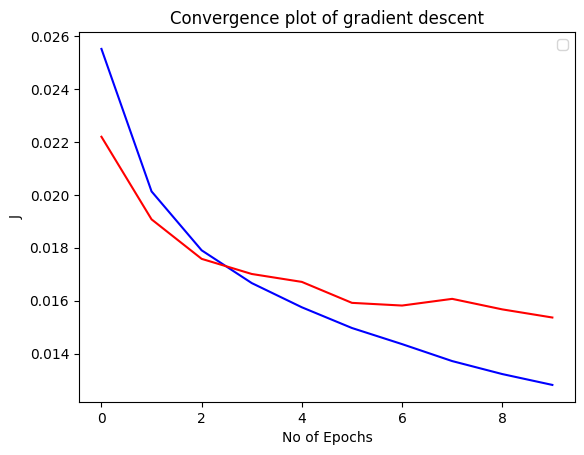

In [8]:
from matplotlib import pyplot as plt
plt.plot(train_history, 'b')
plt.plot(val_history, 'r')
plt.title('Convergence plot of gradient descent')
plt.xlabel('No of Epochs')
plt.ylabel('J')
plt.legend('train loss', 'val loss')
plt.show()

### 5. Validate on test set

Actual airplane	Predicted: airplane
Actual horse	Predicted: horse
Actual automobile	Predicted: automobile
Actual truck	Predicted: automobile
Actual bird	Predicted: bird
Actual bird	Predicted: bird
Actual dog	Predicted: dog
Actual dog	Predicted: deer
Actual airplane	Predicted: airplane
Actual cat	Predicted: dog


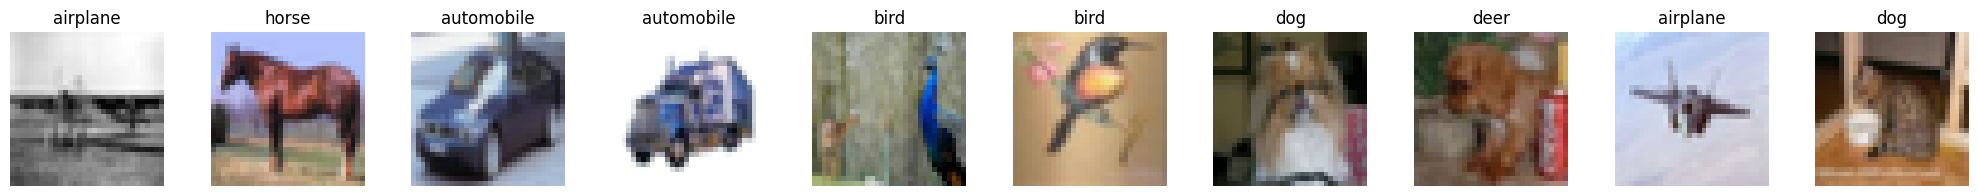

In [9]:
import torchvision

images, labels = next(iter(testloader))
images = images.to(device)
labels = labels.to(device)
    
outputs = model(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(20,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f"Actual {idx_to_class[labels[i].item()]}\tPredicted: {idx_to_class[predicted[i].item()]}")
plt.show()



In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %%')


Accuracy of the network on the 10000 test images: 66.14 %%
